In [4]:
!python -m pip install flwr[simulation] 
#flwr_datasets[vision] torch torchvision matplotlib

  Using cached cryptography-42.0.8-cp39-abi3-manylinux_2_28_x86_64.whl.metadata (5.3 kB)
Using cached cryptography-42.0.8-cp39-abi3-manylinux_2_28_x86_64.whl (3.9 MB)
  Attempting uninstall: cryptography
    Found existing installation: cryptography 41.0.7
ERROR: Cannot uninstall cryptography 41.0.7, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps cryptography==41.0.7'.


In [3]:
!pip install --force-reinstall --no-deps cryptography==41.0.7
#When it gives error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 9.5 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: cryptography
    Found existing installation: cryptography 41.0.7
ERROR: Cannot uninstall cryptography 41.0.7, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps cryptography==41.0.7'.


In [5]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
#from flwr_datasets import FederatedDataset

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

2024-06-06 16:39:29.940378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 16:39:29.940435: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 16:39:29.941893: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 16:39:37,342	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on cuda using PyTorch 2.1.2 and Flower 1.8.0


In [6]:
import torch
import os
import numpy as np

NUM_CLIENTS = 2 # Trying with smaller amount of clients
BATCH_SIZE = 32
CLIENT_FOLDER = "/kaggle/input/bdm-dataset/client"

def load_datasets():
    trainloaders = []
    valloaders = []

    for client_id in range(NUM_CLIENTS):
        client_folder = os.path.join(CLIENT_FOLDER, str(client_id))

        train_x = torch.from_numpy(np.load(os.path.join(client_folder, 'trainx.pyp'), allow_pickle=True))
        train_y = torch.from_numpy(np.load(os.path.join(client_folder, 'trainy.pyp'), allow_pickle=True))
        test_x = torch.from_numpy(np.load(os.path.join(client_folder, 'testx.pyp'), allow_pickle=True))
        test_y = torch.from_numpy(np.load(os.path.join(client_folder, 'testy.pyp'), allow_pickle=True))

        train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
        test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

        trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
        valloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

        trainloaders.append(trainloader)
        valloaders.append(valloader)

    return trainloaders, valloaders

trainloaders, valloaders = load_datasets()

Defining the model

In [20]:
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from keras.utils import to_categorical

In [62]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.cpu(), labels.cpu()
            #images = images.permute(0, 3, 1, 2)
            history = net.fit(images, labels, epochs=1, verbose=0)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {history.history['loss'][0]}, accuracy {history.history['accuracy'][0]}")

def test(model, testloader):
    """Evaluate the network on the entire test set."""
    correct, total, loss = 0, 0, 0.0
    all_labels = []
    all_onehot = []
    all_predictions = []
    all_pred_onehot = []
    for images, labels in testloader:
        #images = images.permute(0, 3, 1, 2)
        all_onehot.extend(labels.numpy())
        outputs = model.predict(images.numpy())
        predicted = torch.from_numpy(np.argmax(outputs, axis=1))
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        all_labels.extend(labels.argmax(dim=1).numpy())
        all_predictions.extend(predicted)
        all_pred_onehot.extend(to_categorical(predicted, num_classes=outputs.shape[1]))
    loss /= len(testloader.dataset)
    accuracy = correct / total
    kappa = cohen_kappa_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    roc = roc_auc_score(all_onehot, all_pred_onehot, multi_class='ovr')
    print(f"Loss: {loss}, accuracy {accuracy}, kappa {kappa}, f1 {f1}, roc {roc}")
    return loss, accuracy, kappa, f1, roc

Federated learning

In [ ]:
def set_parameters(model, parameters: List[np.ndarray]):
    model.set_weights(parameters)

def get_parameters(model) -> List[np.ndarray]:
    return model.get_weights()

Flower Client

In [64]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=3)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        #loss, accuracy, kappa, f1, roc = test(self.net, self.valloader)
        loss, accuracy, kappa, f1, roc = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy), "kappa": float(kappa), "f1": float(f1), "roc": float(roc)}

In [65]:
# Another attempt to use Tensorflow
"""from torchvision import models
import keras
from keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def create_model(input_shape=(32, 32, 3), num_classes=10):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def client_fn(cid: str) -> FlowerClient:
    '''Create a Flower client representing a single organization.'''

    # Load model
    model = create_model()
    net = model
    #net = models.vgg16().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()"""

In [ ]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = models.vgg16()
    num_features = net.classifier[6].in_features
    net.classifier[6] = nn.Linear(num_features, 10)
    net = net.to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

In [66]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

'def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:\n    # Initialize sums for all metrics\n    loss_sum = accuracy_sum = kappa_sum = f1_sum = 0\n    total_examples = 0\n\n    # Compute sums for all metrics\n    for num_examples, m in metrics:\n        loss_sum += num_examples * m["loss"]\n        accuracy_sum += num_examples * m["accuracy"]\n        kappa_sum += num_examples * m["kappa"]\n        f1_sum += num_examples * m["f1"]\n        total_examples += num_examples\n\n    # Compute weighted averages for all metrics\n    loss_avg = loss_sum / total_examples\n    accuracy_avg = accuracy_sum / total_examples\n    kappa_avg = kappa_sum / total_examples\n    f1_avg = f1_sum / total_examples\n\n    return {"loss": loss_avg, "accuracy": accuracy_avg, "kappa": kappa_avg, "f1": f1_avg}'

In [67]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=2,  # Never sample less than 10 clients for training
    min_evaluate_clients=2,  # Never sample less than 5 clients for evaluation
    min_available_clients=2,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-06 19:02:18,727	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 4.0, 'GPU': 2.0, 'memory': 16031917671.0, 'node:__internal_head__': 1.0, 'node:172.19.2.2': 1.0, 'object_store_memory': 8015958835.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 1.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=233455) 2024-06-06 19:02:22.875

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(ClientAppActor pid=233454) Loss: 0.0, accuracy 0.088, kappa -0.0073340991428823, f1 0.025840074320803028, roc 0.49805616605616604


INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=233455) W0000 00:00:1717700611.006275  233520 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
(ClientAppActor pid=233454) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(ClientAppActor pid=233454) I0000 00:00:1717700565.841642  233543 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


KeyboardInterrupt: 

In [2]:
from collections import OrderedDict
from typing import List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
from sklearn.metrics import cohen_kappa_score, f1_score, roc_auc_score
from keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

BATCH_SIZE = 32
CLIENT_FOLDER = "/kaggle/input/bdm-dataset/client"
NUM_CLASSES = 10  # Adjust this based on your number of classes
EPOCHS = 50  # Number of training epochs
NUM_CLIENTS = 5

def load_combined_dataset():
    train_x_list, train_y_list = [], []
    test_x_list, test_y_list = [], []

    for client_id in range(NUM_CLIENTS):
        client_folder = os.path.join(CLIENT_FOLDER, str(client_id))

        train_x_list.append(np.load(os.path.join(client_folder, 'trainx.pyp'), allow_pickle=True))
        train_y_list.append(np.load(os.path.join(client_folder, 'trainy.pyp'), allow_pickle=True))
        test_x_list.append(np.load(os.path.join(client_folder, 'testx.pyp'), allow_pickle=True))
        test_y_list.append(np.load(os.path.join(client_folder, 'testy.pyp'), allow_pickle=True))

    train_x = np.concatenate(train_x_list)
    train_y = np.concatenate(train_y_list)
    test_x = np.concatenate(test_x_list)
    test_y = np.concatenate(test_y_list)

    train_x = torch.from_numpy(train_x)
    train_y = torch.from_numpy(train_y)
    test_x = torch.from_numpy(test_x)
    test_y = torch.from_numpy(test_y)

    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    test_dataset = torch.utils.data.TensorDataset(test_x, test_y)

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, testloader

trainloader, testloader = load_combined_dataset()

def create_model(input_shape=(32, 32, 3), num_classes=NUM_CLASSES):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train(model, trainloader, epochs: int, verbose=False):
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.cpu(), labels.cpu()
            history = model.fit(images.numpy(), labels.numpy(), epochs=1, verbose=0)
        if verbose:
            print(f"Epoch {epoch+1}: train loss {history.history['loss'][0]}, accuracy {history.history['accuracy'][0]}")

def test(model, testloader):
    correct, total, loss = 0, 0, 0.0
    all_labels = []
    all_onehot = []
    all_predictions = []
    all_pred_onehot = []
    for images, labels in testloader:
        all_onehot.extend(labels.numpy())
        outputs = model.predict(images.numpy())
        predicted = torch.from_numpy(np.argmax(outputs, axis=1))
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()
        all_labels.extend(labels.argmax(dim=1).numpy())
        all_predictions.extend(predicted)
        all_pred_onehot.extend(to_categorical(predicted, num_classes=outputs.shape[1]))
    accuracy = correct / total
    kappa = cohen_kappa_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    roc = roc_auc_score(all_onehot, all_pred_onehot, multi_class='ovr')
    print(f"accuracy {accuracy}, kappa {kappa}, f1 {f1}, roc {roc}")
    return accuracy, kappa, f1, roc

# Load the model
model = create_model()

# Train the model
train(model, trainloader, EPOCHS, verbose=True)

# Evaluate the model
accuracy, kappa, f1, roc = test(model, testloader)

Training on cuda
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1717747756.947317      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1: train loss 1.675311803817749, accuracy 0.20000000298023224
Epoch 2: train loss 1.655500054359436, accuracy 0.30000001192092896
Epoch 3: train loss 1.3966467380523682, accuracy 0.4000000059604645
Epoch 4: train loss 1.4471385478973389, accuracy 0.3499999940395355
Epoch 5: train loss 1.3947638273239136, accuracy 0.6000000238418579
Epoch 6: train loss 1.0751221179962158, accuracy 0.6000000238418579
Epoch 7: train loss 0.6857208013534546, accuracy 0.6499999761581421
Epoch 8: train loss 0.5979454517364502, accuracy 0.699999988079071
Epoch 9: train loss 0.4858279228210449, accuracy 0.8500000238418579
Epoch 10: train loss 0.4573298394680023, accuracy 0.75
Epoch 11: train loss 0.4727160334587097, accuracy 0.800000011920929
Epoch 12: train loss 0.3160023093223572, accuracy 0.8500000238418579
Epoch 13: train loss 0.8601919412612915, accuracy 0.699999988079071
Epoch 14: train loss 0.3065650165081024, accuracy 0.8999999761581421
Epoch 15: train loss 0.33564382791519165, accuracy 0.8500000

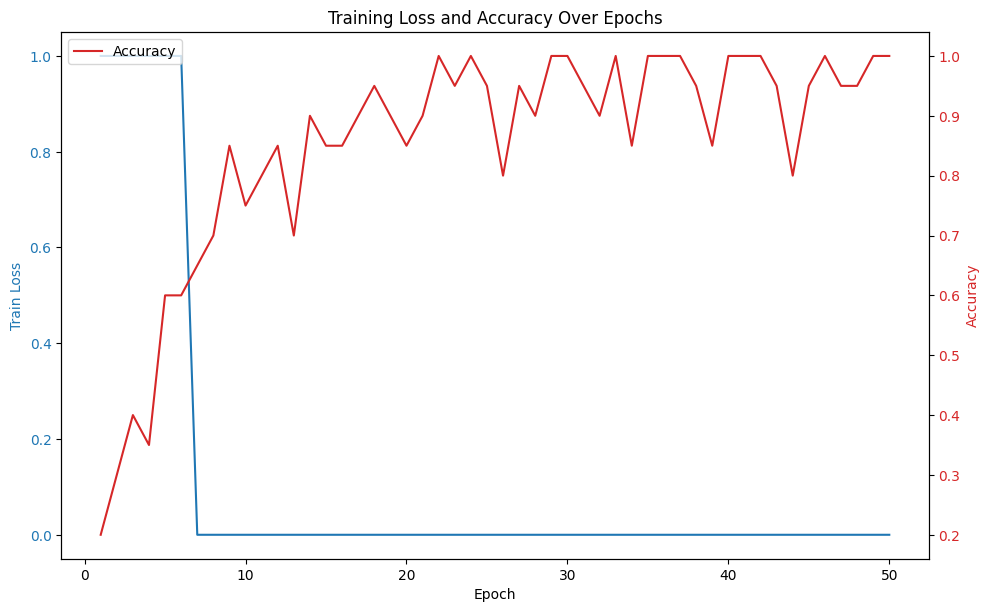

In [19]:
import matplotlib.pyplot as plt

# Data copied from above
data_str = """
Epoch 1: train loss 1.675311803817749, accuracy 0.20000000298023224
Epoch 2: train loss 1.655500054359436, accuracy 0.30000001192092896
Epoch 3: train loss 1.3966467380523682, accuracy 0.4000000059604645
Epoch 4: train loss 1.4471385478973389, accuracy 0.3499999940395355
Epoch 5: train loss 1.3947638273239136, accuracy 0.6000000238418579
Epoch 6: train loss 1.0751221179962158, accuracy 0.6000000238418579
Epoch 7: train loss 0.6857208013534546, accuracy 0.6499999761581421
Epoch 8: train loss 0.5979454517364502, accuracy 0.699999988079071
Epoch 9: train loss 0.4858279228210449, accuracy 0.8500000238418579
Epoch 10: train loss 0.4573298394680023, accuracy 0.75
Epoch 11: train loss 0.4727160334587097, accuracy 0.800000011920929
Epoch 12: train loss 0.3160023093223572, accuracy 0.8500000238418579
Epoch 13: train loss 0.8601919412612915, accuracy 0.699999988079071
Epoch 14: train loss 0.3065650165081024, accuracy 0.8999999761581421
Epoch 15: train loss 0.33564382791519165, accuracy 0.8500000238418579
Epoch 16: train loss 0.3456287086009979, accuracy 0.8500000238418579
Epoch 17: train loss 0.49918776750564575, accuracy 0.8999999761581421
Epoch 18: train loss 0.16027991473674774, accuracy 0.949999988079071
Epoch 19: train loss 0.1924464851617813, accuracy 0.8999999761581421
Epoch 20: train loss 0.3823999762535095, accuracy 0.8500000238418579
Epoch 21: train loss 0.22015734016895294, accuracy 0.8999999761581421
Epoch 22: train loss 0.043328411877155304, accuracy 1.0
Epoch 23: train loss 0.07852645218372345, accuracy 0.949999988079071
Epoch 24: train loss 0.03366542607545853, accuracy 1.0
Epoch 25: train loss 0.1767769157886505, accuracy 0.949999988079071
Epoch 26: train loss 0.6083429455757141, accuracy 0.800000011920929
Epoch 27: train loss 0.13734424114227295, accuracy 0.949999988079071
Epoch 28: train loss 0.1332494020462036, accuracy 0.8999999761581421
Epoch 29: train loss 0.05004057288169861, accuracy 1.0
Epoch 30: train loss 0.006556532345712185, accuracy 1.0
Epoch 31: train loss 0.14316324889659882, accuracy 0.949999988079071
Epoch 32: train loss 0.27419278025627136, accuracy 0.8999999761581421
Epoch 33: train loss 0.03991304710507393, accuracy 1.0
Epoch 34: train loss 0.4197675287723541, accuracy 0.8500000238418579
Epoch 35: train loss 0.012183025479316711, accuracy 1.0
Epoch 36: train loss 0.05521531030535698, accuracy 1.0
Epoch 37: train loss 0.021656090393662453, accuracy 1.0
Epoch 38: train loss 0.17807617783546448, accuracy 0.949999988079071
Epoch 39: train loss 0.21123555302619934, accuracy 0.8500000238418579
Epoch 40: train loss 0.04413207620382309, accuracy 1.0
Epoch 41: train loss 0.016456706449389458, accuracy 1.0
Epoch 42: train loss 0.009810566902160645, accuracy 1.0
Epoch 43: train loss 0.13468065857887268, accuracy 0.949999988079071
Epoch 44: train loss 0.6825190782546997, accuracy 0.800000011920929
Epoch 45: train loss 0.11603542417287827, accuracy 0.949999988079071
Epoch 46: train loss 0.014189200475811958, accuracy 1.0
Epoch 47: train loss 0.12959101796150208, accuracy 0.949999988079071
Epoch 48: train loss 0.1368468701839447, accuracy 0.949999988079071
Epoch 49: train loss 0.04467041790485382, accuracy 1.0
Epoch 50: train loss 0.0012759482488036156, accuracy 1.0
"""

# Parse the data
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
train_loss = []
accuracy = []

lines = data_str.strip().split('\n')
for line in lines:
    parts = line.split(', ')
    loss = float(parts[0].split(' ')[-1][0])
    acc = float(parts[1].split(' ')[-1])
    
    train_loss.append(loss)
    accuracy.append(acc)

# Plot the results
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(epochs, train_loss, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(epochs, accuracy, color=color, label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Training Loss and Accuracy Over Epochs')
plt.legend(loc='upper left')

plt.savefig('training_results.png')
plt.show()

In [2]:
#loss, accuracy, kappa, f1, roc
# These results are copied from HPC output file run with Flower framework
results = [[0.07369317770004273,0.098,0.0,0.017493624772313296,0.5], [0.07367860221862793,0.102,0.0,0.018882032667876584,0.5],
[0.0736990795135498, 0.096, 0.0, 0.01681751824817518, 0.5], [0.0736623682975769,0.098,0.0,0.017493624772313296,0.5],
[0.07368605136871338,0.092, 0.0,0.0155018315018315,0.5],[0.07366459226608277,0.098,0.0,0.017493624772313296,0.5],
[0.07368134307861328,0.102,0.0,0.018882032667876584,0.5],[0.07369496393203735, 0.098, 0.0, 0.017493624772313296,0.5],
[0.07368131732940673,0.092,0.0,0.0155018315018315,0.5],[0.07369762468338013,0.096,0.0,0.01681751824817518,0.5],
[0.07366720724105835,0.118,0.0,0.0249087656529517,0.5],[0.07368455171585082,0.108,0.0,0.021054151624548736,0.5],
[0.07369788122177125, 0.088, 0.0, 0.014235294117647058, 0.5],[0.07369624853134155, 0.078, 0.0, 0.011287569573283859, 0.5],
[0.07367743682861329, 0.116, 0.0, 0.02411469534050179, 0.5],[0.07369798946380615, 0.088,0.0, 0.014235294117647058, 0.5],
[0.07369804573059081, 0.078, 0.0, 0.011287569573283859, 0.5],[0.07366930389404297, 0.118, 0.0, 0.0249087656529517, 0.5],
[0.07367405939102173, 0.116, 0.0,0.02411469534050179,0.5],[0.07368718528747559,0.108,0.0,0.021054151624548736, 0.5],
[0.07367221355438232, 0.116, 0.0, 0.02411469534050179,0.5],[0.07368926286697387,0.108,0.0,0.021054151624548736,0.5],
[0.0736997799873352, 0.078,0.0,0.011287569573283859,0.5],[0.07367106676101684, 0.118, 0.0, 0.0249087656529517, 0.5],
[0.07369688892364502, 0.088, 0.0,0.014235294117647058,0.5],[0.07367294454574586,0.118,0.0,0.0249087656529517,0.5],
[0.07367047643661499, 0.116,0.0,0.02411469534050179,0.5],[0.07369634819030761,0.088,0.0,0.014235294117647058,0.5],
[0.07369114208221436,0.108,0.0,0.021054151624548736,0.5],[0.07370137739181519,0.078,0.0,0.011287569573283859,0.5],
[0.07367312622070313,0.118,0.0,0.0249087656529517,0.5],[0.07366983127593994,0.116,0.0,0.02411469534050179,0.5],
[0.07369171714782714,0.108,0.0,0.021054151624548736,0.5],[0.07369663190841674,0.088,0.0,0.014235294117647058,0.5],
[0.07370224571228028,0.078,0.0,0.011287569573283859,0.5],[0.07369562578201294,0.088,0.0,0.014235294117647058,0.5],
[0.0736742615699768,0.118,0.0,0.0249087656529517,0.5],[0.07369338703155517,0.108,0.0,0.021054151624548736,0.5],
[0.07366869783401489,0.116,0.0,0.02411469534050179,0.5],[0.07370373725891113,0.078,0.0,0.011287569573283859,0.5],
[0.07369434118270873,0.108,0.0,0.021054151624548736,0.5],[0.07366797256469726,0.116,0.0,0.02411469534050179,0.5],
[0.07370463800430298,0.078,0.0,0.011287569573283859,0.5],[0.07367580413818359,0.118,0.0,0.0249087656529517,0.5],
[0.07369581747055054,0.088,0.0,0.014235294117647058,0.5],[0.07369540691375732,0.088,0.0,0.014235294117647058,0.5],
[0.07369540309906006,0.108,0.0,0.021054151624548736,0.5],[0.07366730070114136,0.116,0.0,0.02411469534050179,0.5],
[0.07370534324645996,0.078,0.0,0.011287569573283859,0.5],[0.07367661142349244,0.118,0.0,0.0249087656529517,0.5]]

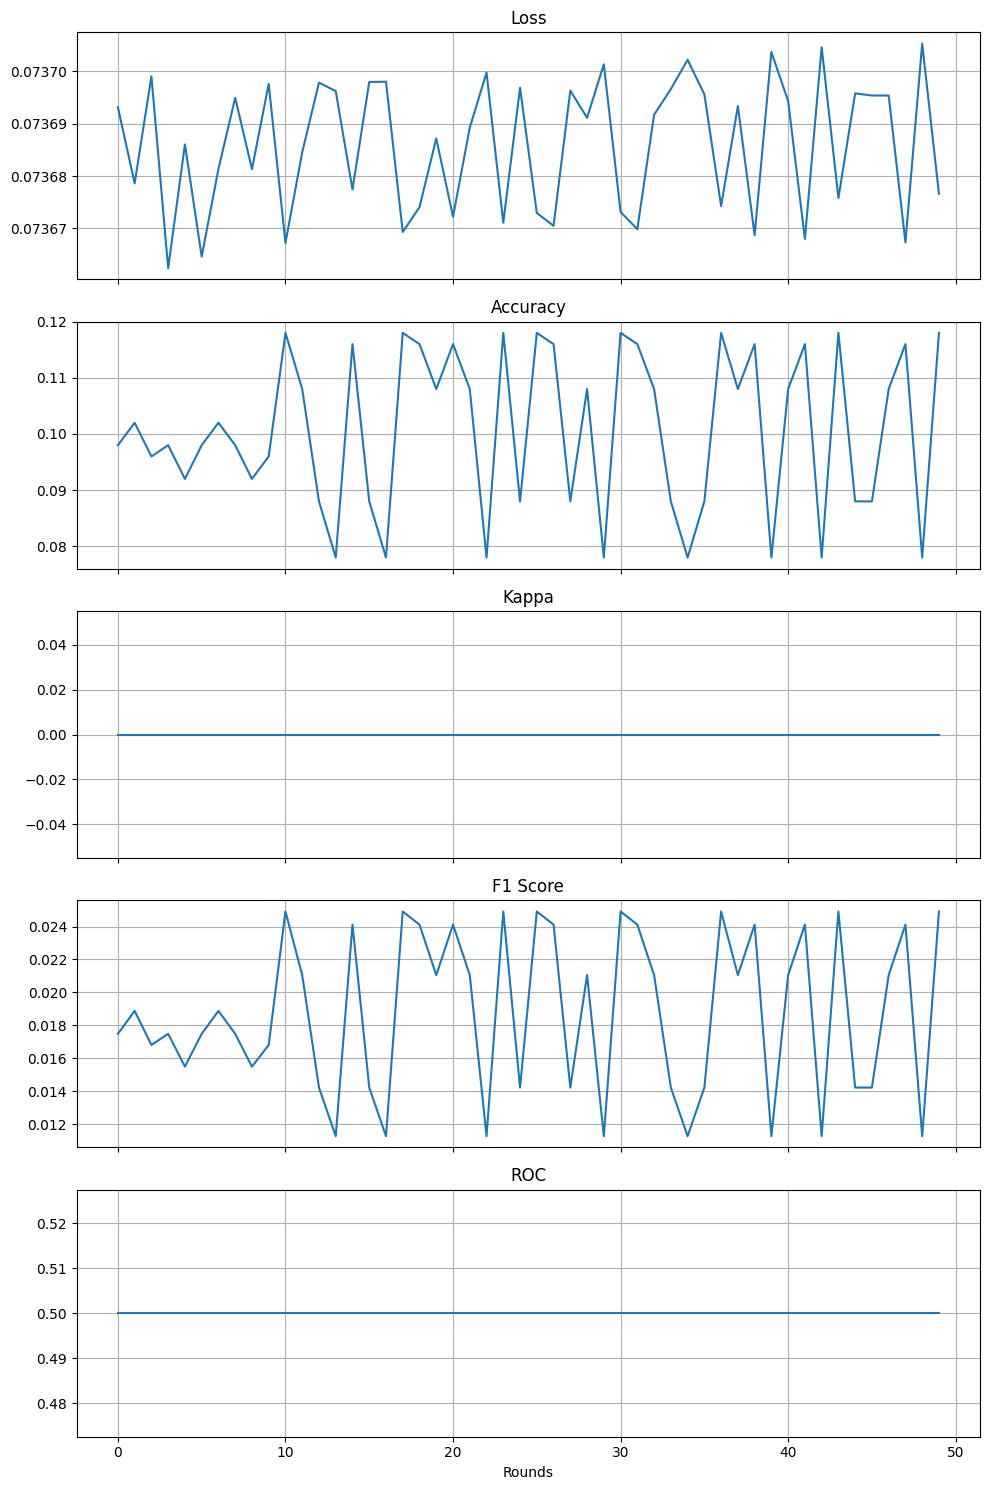

In [5]:
# Transpose results to get separate lists for each metric
results = np.array(results).T

# Plot the results
fig, axs = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
metrics = ['Loss', 'Accuracy', 'Kappa', 'F1 Score', 'ROC']

for i, ax in enumerate(axs):
    ax.plot(results[i])
    ax.set_title(metrics[i])
    ax.grid(True)

plt.xlabel('Rounds')
plt.tight_layout()
plt.savefig('results_plot.png')
plt.show()